# TMA4320: Biofysikkprosjekt
Av: Ingrid M. Løvold, Oskar Farbrot og Cecilia M. B. Eide

## Introduksjon
I dette prosjektet har vi benyttet Monte Carlo-metode for å simulere polymerfolding. Polymerer er kjemiske forbindelser som er bygd opp av store kjedeformede molekyler man kaller monomerer. DNA, RNA og proteiner er eksempler på naturlige polymerer, så ved å forstå mer om polymerer kan vi også lære mer om grunnlaget til levende organismer. Vi bruker en forenklet 2D modell, med monomerene som punktverdier i et koordinatsystem, for polymerfolding til å si noe om foldingen. Vi vil se på hvordan temperaturen og  påvirker folding, samt diskutere hvor gode modellene våre er.


## Modell for polymerfolding
Begynner med å importere nødvendige biblioteker.

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time

For å representere en polymer numerisk bruker vi et array av posisjonskoordinatene til hvert monomer. Det er et N x 2 array, der N er antall monomerer, og vi får N elementer av posisjonsvektorer på formen [x, y]. Indeksen i arrayet viser gjennomgående til et spesifikt monomers posisjon. Vi slipper da å lagre og vurdere alle de tomme posisjonene og får mer effektiv kode. Vi bruker et diskret koordinatsystem som er et kvadratisk gitter med avstand lik 1.

I flere av simulisasjonene tar vi utgangspunkt i en rett polymer og definerer funksjonen makeStraightPolymer(N) som vist i kodeblokken under. Denne tar inn lengden på en polymer, N, og gir ut en horisontal polymer midt i et koordinatsystem med størrelse N x N. Er N et partall vil den legge seg på den øverste av de to midterste radene, men dette påvirker ikke koden videre.

In [86]:
def makeStraightPolymer(N): #Make a straight polymer with length N
    y = int(N/2) + 1 #arrange at 1/2 of length in y-direction (middle, depending on odd/even N)
    koord = np.zeros((N, 2), dtype=int)
    
    for i in range(N):
        koord[i] = [i+1, y]
    
    return koord #N x 2 matrix containing coordinates for monomer 1-N position, indexed 0 - (N-1)

For å simulere en folding til en polymer bruker vi rotasjon om en monomer. Disse rotasjonene er forenklet ved at de foregår i et 2D plan og at de alltid vil være en knekk på 90 grader som følge av at de foregår i et kvadratisk gitter, enten med eller mot klokka. Funksjonen rotatePolymer(polymer, koord, rot) tar inn et polymer, en tilfeldig rotasjonsretning og en tilfeldig monomer polymer polymere skal rotere om. Dette kommer vi tilbake til senere i prosjektet. Vi roterer alltid den korteste delen av polymeren slik at vi ikke havner utenfor koordinatsystemet vi har laget. Det blir ingen fysisk forskjell på å roterer den korte enden i en rotasjonsretning og på å rotere den lange enden i motsatt rotasjonsretning fordi sluttposisjonen blir lik, bare med annen orientering i rommet. Siden rotasjonsretning er tilfeldig kan vi dermed velge å alltid rotere den korte delen uten at det endrer resultatet. 

Vi ser også bort ifra rotasjoner rundt endemonomerene fordi det ikke gir noen energiendring. En eventuell energiendring for polymeren skyldes svake vekselvirkninger mellom monomerer som ikke allerede er bundet av kovalente bindinger. En rotasjon rundt et endepunkt på polymeren vil ikke gi en energiendring, da ingen monomerer endrer posisjoner relativt til hverandre og derfor ikke vil oppleve noen endrede vekselvirkninger.

Polymeren som system ønsker å minimere energien sin, og senere i oppgaven vil vi se at den som hovedregel kun endrer 
tilstand dersom den totale energiendringen er mindre enn null. Dersom en rotasjon om et endepunkt likevel inntreffer 
grunnet termiske fluktasjoner som tillater ugunstige endringer, kan vi dessuten også se at dette ikke utgjør en reell 
endring for systemet vi simulerer. Vår løsning av oppgaven velger alltid å rotere den korteste enden fra rotasjonsmonomeren, 
som for et endepunkt ikke vil inneholde noen monomerer i det hele tatt og derfor åpenbart ikke endre polymeren. Skulle vi 
likevel valgt å rotere den lengste enden, vil heller ikke monomerenes posisjoner endres relativt til hverandre. Å tillate 
en slik rotasjon i simuleringen vil være det samme som å endre polymerens orientering i koordinatsystemet, og utgjør ikke 
en reell forskjell for polymeren. Uansett metode vil rotasjon om endepunkt være et urelevant tilfelle, og vi har derfor 
vurdert at det ikke er hensiktsmessig å inkludere koordinater for endemonomerer i utvalget av rotasjonsmonomerer.

In [87]:
def rotatePolymer(polymer, koord, rot): #rotates polymer around koord, clockwise or counterclockwise based on rot value.
    polymer = np.copy(polymer)
    for i in range(len(polymer)): #Kan ta (1, len(polymer) - 1) for raskere kode, siden vi ikke tar hensyn til rot om endemonomerer
        if polymer[i][0] == koord[0] and polymer[i][1] == koord[1]:
            rot_om = i #index of monomer at rotation koordinate
        
    if rot_om > len(polymer)/2: #Rotates monomers with index lower than the rotation-coordinate if this is the shortest tail
        for i in range(rot_om + 1, len(polymer)):
            avstandsvektor = polymer[i] - polymer[rot_om]
            
            if rot == True: #Clockwise
                avstandsvektor[0], avstandsvektor[1] = avstandsvektor[1], -avstandsvektor[0]
                polymer[i] = polymer[rot_om] + avstandsvektor
            
            else: #Counter-clockwise
                avstandsvektor[0], avstandsvektor[1] = -avstandsvektor[1], avstandsvektor[0]
                polymer[i] = polymer[rot_om] + avstandsvektor
    
    else: #Rotates monomers with index higher than the rotation-coordinate if this is the shortest tail
        for i in range(rot_om):
            avstandsvektor = polymer[rot_om] - polymer[i] 
            if rot == True: #Clockwise
                avstandsvektor[0], avstandsvektor[1] = avstandsvektor[1], avstandsvektor[0]
                polymer[i] = polymer[rot_om] + avstandsvektor
            
            else: #Counter-clockwise
                avstandsvektor[0], avstandsvektor[1] = -avstandsvektor[1], -avstandsvektor[0]
                polymer[i] = polymer[rot_om] + avstandsvektor
            
    return polymer #rotated polymer (not necissarily intact)

Vi har i rotasjonsjonsfunksjonen ikke tatt hensyn til om den nye polymeren er fysisk gyldig. Et polymer skal være sammenhengende og det skal ikke foldes slik at monomerer havner i samme koordinater, slik at de ligger oppå hverandre. Vi har derfor laget funksjonen polymerIntact(polymer, N) som returnerer false dersom to eller flere monomerer ligger i samme koordinat eller om monomerer med kovalent binding, monomer med indeks [i] med monomerer med indeks [i+1] og [i-1], ikke er nærmeste nabo, i henhold til oppgave 1 i prosjektbeskrivelsen. Med nærmeste nabo mener vi at avstanden er en og de ligger inntil hverandre.

Selv om den ikke rotasjonsfunksjonen direkte kontrollerer at polymeren er sammenhengende gir den ikke noe rom for å lage en polymer som ikke er det, noe vi vil kommentere videre senere der vi skriver en mer effektiv kode.

In [88]:
def polymerIntact(polymer, N): #Checking predefined rules for intact polymer (intact -> True)
    #Checking if polymer contains N monomers
    if len(polymer) != N:
        return False
    
    #Checking if any monomers are overlapping (two or more at same coord.)
    unique_positions = set() # Convert numpy array to tuple for set insertion
    for monomer in polymer:
        pos = tuple(monomer)
        unique_positions.add(pos)

    if len(unique_positions) != N: #identical coordinates not allowed
        return False
    
    #Verifying that each monomer is neighbouring the previos one. (this should always be the case with the way our polymers are made and handeled throughut the project?)
    for i in range(len(polymer) - 1):
        dx = abs(polymer[i][0] - polymer[i + 1][0])
        dy = abs(polymer[i][1] - polymer[i + 1][1])
        if not ((dx == 1 and dy == 0) or (dx == 0 and dy == 1)):
            return False
    
    return True

Vi har nå satt opp forutsetninger for å simulere en velykket velykket. Det er derimot mer interresant å se på en simulering med N_s forsøk på rotsasjon, noe vi har satt opp i funksjonen under. Denne tar inn et gyldig polymer, for eksempel en konstruert fra funksjonen makeStraightPolymer, forsøker å folde den et gitt antall ganger (N_s) og returnerer sluttpolymererpolymeren og antall vellykkede rotasjoner. Vi gjør rotasjonsretning og hvilket monomer vi roterer om tilfeldig ved å generere pseudotilfeldige heltall fra numpy.random biblioteket. Denne modellen tar ikke hensyn til polymerens energi, noe vi kommer til senere.

In [89]:
def N_simuleringer(N, N_s): #simulates N_s rotation attempts of a polymer of length N
    counter = 0 #for tracking number of legal rotations in the simulation
    polymer = makeStraightPolymer(N)
    
    for i in range(N_s):
        koord = polymer[np.random.randint(1, N-1)] #Excludes end-monomers
        rot = np.random.randint(0, 2)
        twisted_polymer = rotatePolymer(polymer, koord, rot) #rotate the existing polymer
        
        if polymerIntact(twisted_polymer, N) == True: #keep the rotated polymer only if the rotation is valid
            counter += 1
            polymer = twisted_polymer
            
    return polymer, counter #returns end-polymer after N_s attempts and number = total valid rotations

For å illustrere en polymer, noe vi vil bruke for å vise sluttpolymerene senere i oppgaven, bruker vi funksjonen illustratePolymer(polymer) som vist i kodeblokken under.

In [90]:
def illustratePolymer(polymer, name):
    
    M = len(polymer) + 2 #Adds two coordinates to create open slots on each side of the polymer for a more visually pleasing plot
    
    x = np.arange(0, M, 1)
    y = np.arange(0, M, 1)
    
    insertPolymer = np.zeros((M, M))
        
    for i in range(len(polymer)):  
        insertPolymer[int(polymer[i][1])][int(polymer[i][0])] = i+1 #each monomer placed in grid and assigned increasing int values thorughout the chain 
        plt.text(int(polymer[i][0]), int(polymer[i][1]), str(i+1), ha='center', va='center') #print assigned number
    
    plt.title(name)
    plt.pcolormesh(x, y, insertPolymer) #colour distinguish
    plt.show()

Vi har nå beskrevet metoden vi skal bruke for å simulere en polymerfolding, men det er kode som kan ha lang kjøretid og vi vil derfor gjøre den så effektiv som mulig. Vi har derfor utforsket hvordan vi kan skrive en kode med lik funksjonalitet, men som kjører på kortere tid. Vi har også oppdaget at måten vi behandler polymeren og dens rotasjoner i koordinatsystemet gjør det unødvendig å sjekke enkelte av kravene for en intakt polymer, da disse ikke kan bli brutt gjennom programmet. Vi har derfor også inkludert og analysert en versjon av koden som ekskluderer unødvendige sjekker fullstendig. 

Nedenfor er "slow" den initielle koden, "fast" sikter til koden som gjør det samme men kjører raskere, og "fastfast" er koden som er optimalisert og samtidig strippet for overflødige sjekker. Videre vil vi sammenligne og diskutere funksjonaliteten til de tre alternativene. 

In [91]:
"""--------------------SLOW--------------------"""
def polymerIntact_s(polymer, N): #Checking predefined rules for intact polymer (intact -> True)
    #Checking if polymer contains N monomers
    if len(polymer) != N:
        return False
    
    #Checking if any monomers are overlapping (two or more at same coord.)
    for i in range(len(polymer)-1):
        for j in range(i+1, len(polymer)):
            result_variable = (polymer[i] == polymer[j]).all()
            if result_variable == True:
                return False
    
    #Verifying that each monomer is neighbouring the previos one.
    test = 0

    for i in range(len(polymer)-1):
        if polymer[i+1][0] == polymer[i][0] and polymer[i+1][1] + 1 == polymer[i][1]:
            test += 1
        elif polymer[i+1][0] == polymer[i][0] and polymer[i+1][1] - 1 == polymer[i][1]:
            test += 1
        elif polymer[i+1][0] + 1 == polymer[i][0] and polymer[i+1][1] == polymer[i][1]:
            test += 1
        elif polymer[i+1][0] - 1 == polymer[i][0] and polymer[i+1][1] == polymer[i][1]:
            test += 1

    if test == len(polymer)-1:
        return True
    else:
        return False
    

def rotatePolymer_s(polymer, koord, rot): 
    polymer = np.copy(polymer)
    for i in range(len(polymer)): #Kan ta (1, len(polymer) - 1) for raskere kode, siden vi ikke tar hensyn til rot om endemonomerer
        if polymer[i][0] == koord[0] and polymer[i][1] == koord[1]:
            rot_om = i
        
    if rot_om > len(polymer)/2: #Rotates monomers with index lower than the rotation-coordinate if that is the shortest tail
        for i in range(rot_om + 1, len(polymer)):
            avstandsvektor = polymer[i] - polymer[rot_om]
            
            if rot == True: #Clockwise
                avstandsvektor[0], avstandsvektor[1] = avstandsvektor[1], -avstandsvektor[0]
                polymer[i] = polymer[rot_om] + avstandsvektor
            
            else: #Counter-clockwise
                avstandsvektor[0], avstandsvektor[1] = -avstandsvektor[1], avstandsvektor[0]
                polymer[i] = polymer[rot_om] + avstandsvektor
    
    else: #Rotates monomers with index higher than the rotation-coordinate if that is the shortest tail
        for i in range(rot_om):
            avstandsvektor = polymer[rot_om] - polymer[i] 
            if rot == True: #Clockwise
                avstandsvektor[0], avstandsvektor[1] = avstandsvektor[1], avstandsvektor[0]
                polymer[i] = polymer[rot_om] + avstandsvektor
            
            else: #Counter-clockwise
                avstandsvektor[0], avstandsvektor[1] = -avstandsvektor[1], -avstandsvektor[0]
                polymer[i] = polymer[rot_om] + avstandsvektor
            
    return polymer


def N_simuleringer_s(N, N_s): #simulates N_s rotation attempts of a polymer of length N
    counter = 0
    polymer = makeStraightPolymer(N)
    
    for i in range(N_s):
        koord = polymer[np.random.randint(1, N-1)] #Excludes end-monomers
        rot = np.random.randint(0, 2)
        twisted_polymer = rotatePolymer_s(polymer, koord, rot)
        
        if polymerIntact_s(twisted_polymer, N) == True:
            counter += 1
            polymer = twisted_polymer
            
    return polymer, counter

In [92]:
'''--------------------FAST--------------------'''
def polymerIntact_f(polymer,N):
    #Sjekker om polymeren har N monomerer    
    if len(polymer) != N:
        return False
    
    #Checking if any monomers are overlapping (two or more at same coord.)
    unique_positions = set()
    for monomer in polymer:
        # Convert numpy array to tuple for set insertion
        pos = tuple(monomer)
        unique_positions.add(pos)

    if len(unique_positions) != N:
        return False
    
    #Verifying that each monomer is neighbouring the previos one. (this should always be the case with the way our polymers are made and handeled throughut the project?)
    for i in range(len(polymer) - 1):
        dx = abs(polymer[i][0] - polymer[i + 1][0])
        dy = abs(polymer[i][1] - polymer[i + 1][1])
        if not ((dx == 1 and dy == 0) or (dx == 0 and dy == 1)):
            return False
        
    return True

def rotatePolymer_f(polymer, koord, rot): 
    polymer = np.copy(polymer)
    rot_om = np.where((polymer == koord).all(axis=1))[0][0] #determine index of monomer on rotationcoordinate
    avstandsvektorer = polymer - polymer[rot_om] 
    
    if rot: #clockwise
        avstandsvektorer[:, 0], avstandsvektorer[:, 1] = avstandsvektorer[:, 1], -avstandsvektorer[:, 0]
    else: #counterclockwise
        avstandsvektorer[:, 0], avstandsvektorer[:, 1] = -avstandsvektorer[:, 1], avstandsvektorer[:, 0]
    
    if rot_om > len(polymer) / 2: #rotate part with lowest index
        polymer[rot_om+1:] = polymer[rot_om] + avstandsvektorer[rot_om+1:]
    else: #rotate part with highest index
        polymer[:rot_om] = polymer[rot_om] + avstandsvektorer[:rot_om]
    
    return polymer

def N_simuleringer_f(N, N_s): #simulates N_s rotation attempts of a polymer of length N
    counter = 0
    polymer = makeStraightPolymer(N)
    
    for i in range(N_s):
        koord = polymer[np.random.randint(1, N-1)] #Excludes end-monomers
        rot = np.random.randint(0, 2)
        twisted_polymer = rotatePolymer_f(polymer, koord, rot)
        
        if polymerIntact_f(twisted_polymer, N) == True:
            counter += 1
            polymer = twisted_polymer
            
    return polymer, counter


In [93]:
'''--------------------FASTFAST--------------------'''
def polymerIntact_ff(polymer,N):   
    #Checking if any monomers are overlapping (two or more at same coord.)
    unique_positions = set()
    for monomer in polymer:
        # Convert numpy array to tuple for set insertion
        pos = tuple(monomer)
        unique_positions.add(pos)

    if len(unique_positions) != N:
        return False        
    return True

def N_simuleringer_ff(N, N_s): #simulates N_s rotation attempts of a polymer of length N
    counter = 0
    polymer = makeStraightPolymer(N)
    
    for i in range(N_s):
        koord = polymer[np.random.randint(1, N-1)] #Excludes end-monomers
        rot = np.random.randint(0, 2)
        twisted_polymer = rotatePolymer_f(polymer, koord, rot)
        
        if polymerIntact_ff(twisted_polymer, N) == True:
            counter += 1
            polymer = twisted_polymer
            
    return polymer, counter

Hovedforskjellen på "slow" og "fast" er bruken av vektoroperasjoner fremfor nestede løkker. Der "slow" baserer seg på kondisjoner som må testes ved å iterere gjennom alle monomerene, benytter "fast" innebygde numpy-funksjoner som utfører operasjoner på hele arrayet (eller settet). Fordelen med "slow" er imidlertid at den for mange kan være enklere å lese, og stegene oppleves mer intuitive da de er en mer direkte oversettelse av vår tankemåte. Det kan også være enklere å forsikre seg om at koden gjør nøyaktig det du ønsker, da du ikke er avhengig av å stole på funksjonaliteten til innebygde funksjoner. Det er likevel ikke noen tvil om at den raske koden er å foretrekke. 

Vi har også valgt å inkludere "fastfast" i denne sammenligningen. I funksjonen polymerIntact tester vi at alle betingelsene for et intakt polymer er oppfylt. Det er imidlertid unødvendig å teste lengden på polymeren og verifisere naboforhold da polymeren gjennom simuleringen behandles på en måte som gjør at disse ikke vil endres. "fastfast" er uten disse to stegene, men ellers identisk til "fast".

Forskjellen i kjøretid kan sees ved å ta et enkelt polymer som eksempel og printe kjøretiden for de to forskjellige versjonene. I dette tilfellet har vi brukt et av polymerene fra oppgave 1 som eksempel. Her er N=15 og N_S=1000. 

In [94]:
startf = time.time()
bf = N_simuleringer_f(15, 1000)[0]
endf = time.time()

starts = time.time()
bs = N_simuleringer_s(15, 1000)[0]
ends = time.time()

startff = time.time()
bff = N_simuleringer_ff(15, 1000)[0]
endff = time.time()

divf = (ends-starts) / (endf-startf)
divff = (ends-starts) / (endff-startff)

print("Kjøretid treg kode: ", ends-starts, "sek")
print("Kjøretid rask kode: ", endf-startf, "sek")
print("Kjøretid superrask kode: ", endff-startff, "sek")

print(f"Den raske koden er {divf} ganger raskere enn den trege for den valgte test-polymeren")
print(f"Den kjemperaske koden er {divff} ganger raskere enn den trege for den valgte test-polymeren")


Kjøretid treg kode:  0.2701427936553955 sek
Kjøretid rask kode:  0.041048288345336914 sek
Kjøretid superrask kode:  0.03040933609008789 sek
Den raske koden er 6.581097642432726 ganger raskere enn den trege for den valgte test-polymeren
Den kjemperaske koden er 8.883547896445204 ganger raskere enn den trege for den valgte test-polymeren


Vi kan se at den prosentvise forskjellen er betydelig, men opplever likevel at samtlige koder gjør jobben på akseptabel tid. Det virkelige forskjellen kommer nemlig ikke til syne før vi kjører større simuleringer hvor vi også endrer lengden på polymeren. På korte polymerer er det ikke spesielt tidkrevende å iterere gjennom alle monomerene sammenlignet med å bruke numpy-operatorene. Etterhvert som polymerene vokser vil imidlertid de nøstede løkkene øke kjøretiden betraktelig, samtidig som tidsbruken for vektoroperasjonene forblir lav og noenlunde konstant. 

Nedenfor er tiden per simulason som funksjon av polymerens lengde N for "fast" og "slow" (N_s = 100 = konst.) plottet sammen. Det er også inkludert et plott hvor vi ser den relative hastighetsforskjellen i kjøretid for de to kodene. Denne viser tydelig hvordan "slow" i økende grad blir ugunstig ved høyere N. 

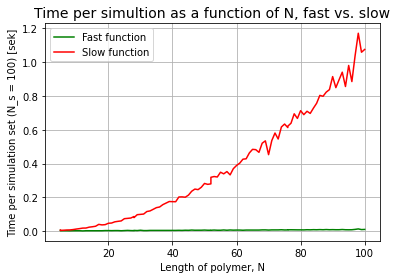

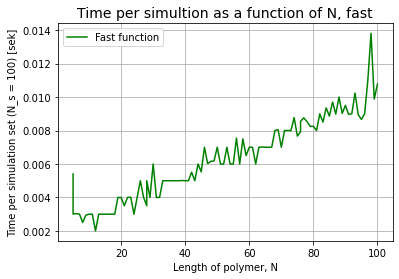

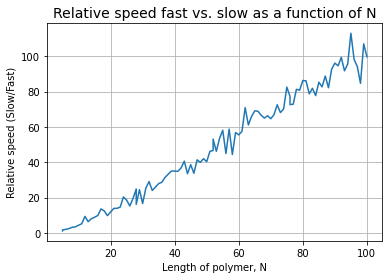

In [95]:
d = 100 #number of datapoints

"""-------------------Tid som funksjon av N-------------------"""
N_array = np.linspace(5,100,d, dtype = int)

time_f = np.zeros(d)
time_s = np.zeros(d)
div_array = np.zeros(d)
count = 0

for N in N_array:
    start_f = time.time()
    N_simuleringer_f(N, 100)
    end_f = time.time()
    
    time_f[count] = end_f-start_f
    
    start_s = time.time()
    N_simuleringer_s(N, 100)
    end_s = time.time()
    
    time_s[count] = end_s-start_s
    div_array[count] = (end_s-start_s) / (end_f-start_f)
    
    count +=1


plt.plot(N_array, time_f, 'g', label = "Fast function")
plt.plot(N_array, time_s, 'r', label = "Slow function")
plt.xlabel('Length of polymer, N')
plt.ylabel('Time per simulation set (N_s = 100) [sek]')
plt.title('Time per simultion as a function of N, fast vs. slow', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

plt.plot(N_array, time_f, 'g', label = "Fast function")
plt.xlabel('Length of polymer, N')
plt.ylabel('Time per simulation set (N_s = 100) [sek]')
plt.title('Time per simultion as a function of N, fast', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

plt.plot(N_array, div_array)
plt.xlabel('Length of polymer, N')
plt.ylabel('Relative speed (Slow/Fast)')
plt.title('Relative speed fast vs. slow as a function of N', fontsize=14)
plt.grid(True)
plt.show()

## Simulasjon av polymerfolding uten energi

Vi kjører nå to simulasjoner av en rett polymer med 15 monomerer som foldes. I den første simulasjonen blir den forsøkt foldet 4 ganger og i den andre blir det forsøkt 1000 ganger. Vi illustrerer deretter sluttpolymeren i de to simulasjonene og ser om vi kan bruke dette til å si noe om foldingen.

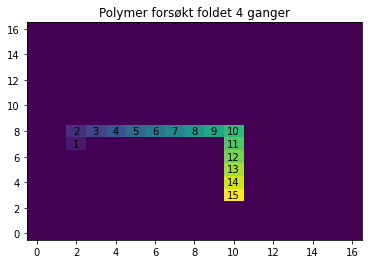

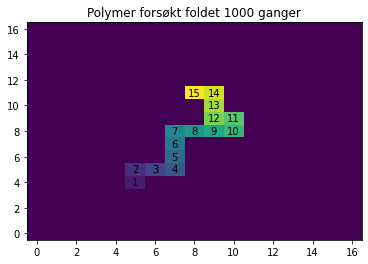

In [96]:
a = N_simuleringer(15, 4)[0]
b = N_simuleringer(15, 1000)[0]

illustratePolymer(a, 'Polymer forsøkt foldet 4 ganger')
illustratePolymer(b, 'Polymer forsøkt foldet 1000 ganger')

Figurene viser sluttposisjonen til et polymer med 15 monomerer (N=15) som er forsøkt rotert henholdsvis 4 og 1000 ganger. Polymeren med klart flest rotasjonsforsøk er som forventet mer sammenkveilet og kompakt. Det er imidlertid verdt å merke seg at selv om polymer b er forsøkt rotert 250 ganger mer enn polymer a, viser plottet langt under 250 ganger flere vellykkede rotasjoner. 

Dette skyldes at det blir færre gyldige rotasjoner etter de første rotasjonsforsøkene og gjennomførte rotasjoner per rotasjonsforsøk vil bli lavere for polymeren med mange rotasjonsforsøk. Forskjellen i prosentandel gyldige rotasjoner blir tydelig i dette tilfellet hvor vi inkluderer polymer a med kun 4 forsøk. Sannsynligheten for at de fire første rotasjonene er vellykkede er høy sammenlignet med et allerede kveilet polymer.  For svært lave N_s vil alle rotasjonsforsøkene skje i stadiet hvor de aller fleste kveilingene fører til færre muligheter. Prosentandelen vellykkede vil derfor synke med N_s i dette området. 

Det er imidlertid ikke gitt at høyere N_s alltid vil gi lavere prosentandel gyldige rotasjoner for høyere N_s. Polymerer vil for de første forsøkene ha svært mange muligheter for vellykkede rotasjoner. I en startperiode vil de aller fleste vellykkede rotasjonene gi mindre sannsynlighet for at den neste kan være vellykket. Etter polymeren har gjennomført noen initielle foldinger vil det være andre fordelinger mellom mulige rotasjoner som øker antall mulige rotasjoner (polymeren kveiler seg ut), og dem som minker antallet mulige rotasjoner (polymeren komprimeres). 

For høyere N_s vil polymerens lengde ha mer å si for prosentandelen vellykkede rotasjoner. I plottet under er prosentandel gyldige rotasjoner for polymer med lengde N plottet for tre forskjellige (men høye) N_s. For et kort polymer (eks. 3-20) vil det i stor grad være tilfeldigheter som avgjør om det gjennomføres gunstige eller ugunstige rotasjoner for suksessprosenten, og det er ingen klar sammenheng med antall forsøk, N_s. Dette skyldes at polymeret endrer form og kveiler seg både inn og ut, uten å nærme seg en spesiell tilstand. Lange polymerer vil imidlertid etter hvert kunne havne i et stadie hvor veldig mange av polymerene er mer eller mindre innespærret og dermed er uegnede som rotasjonspolymerer. Når dette skjer er prosenten vellykkede rotasjoner veldig lav. Simulasjonen som forsøker flest rotasjoner etter dette stadiet vil ha den laveste prosenten vellykkede rotasjoner. Vi kan se av plottet at for valgte N_s gjelder dette ca fra N=40/50.  

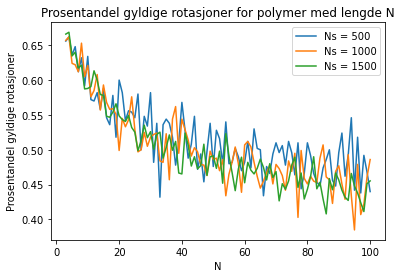

In [97]:
def prosentGyldigRotasjon(N_end, N_s):
    N_list = np.arange(3, N_end + 1, 1) #Gir ikke noe å se på under 3
    prosent = np.zeros(len(N_list))

    for i in range(len(N_list)):
        N = N_list[i]
        prosent[i] = N_simuleringer(N, N_s)[1]/N_s
    
    return N_list, prosent

N_s_list = [500, 1000, 1500]
N_end = 100

plt.xlabel('N')
plt.ylabel('Prosentandel gyldige rotasjoner')
plt.title('Prosentandel gyldige rotasjoner for polymer med lengde N')

for i in N_s_list:
    N_liste, prosent = prosentGyldigRotasjon(N_end, i)
    plt.plot(N_liste, prosent, label = 'Ns = ' + str(i))

plt.legend()
plt.show() 

Polymeren som forsøkes rotert 4 ganger får en energi som er høyere (nærmere null) enn polymeren som forsøkes tvistet 1000 ganger. Energien til polymeret avhenger av hvor mange vekselvirkende monomerer man har. Det vil danne seg flere vekselvirkende monomerer hvis man roterer mange ganger. Det er naturlig at man med med mange forsøk på rotasjon også får flere rorasjoner som er vellykket. 


## Polymerens energi

Vi har til nå i prosjektet ikke tatt hensyn til vekselvirkninger mellom monomerene i polymerene, som gir opphav til en energiendring ved rotasjoner. For å få dette inn i modellen lager vi en vekselsvirkningsmatrise V, i funksjonen make_V(polymer, v_Energy), som angir vekselsvirkning mellom to monomerer. Indeksen V[i][j] viser vekselvirkningen mellom monomer i og j. Vi antar at monomerer kun vekselvirker hvis de er nærmeste naboer og at de ikke opplever vekselvirkning fra monomerene ved siden av seg i rekken, altså ikke mellom monomerer som har kovalent binding, eller fra seg selv. Derfor må elementene i diagobalen, overdiagonalen og underdiagonalen. Videre må matrisen være symetrisk siden vekselvirkningen mellom monomer i og j, må være like vekselvirkningen mellom j og i (V[i][j] = V[j][i]). Når vi lager V i denne funksjonen antar vi at alle elementene som ikke er lik null har samme verdi, men dette er ikke egentlig noe krav. Vi vil se mer på dette senere i oppgaven.

In [98]:
def make_V(polymer, v_Energy):
    N  = len(polymer)
    V = np.full((N, N), v_Energy)
    for i in range(N):
        for j in range(N):
            if i == j:
                V[i][j]=0
            elif i == j+1:
                V[i][j]=0
                V[j][i]=0
    return V

For å finne energien til et polymer må vi summere over alle vekselsvirkningene. Dette gjør vi med å gange V-matrisen med operatoren b, som er 1 hvis de to monomerene vekselvirker og 0 hvis de ikke vekselvirker. Man finner da energien fra summen av elementene i den nye matrisen delt på to, slik at vekselvirkning mellom to monomerer ikke teller to ganger.

In [99]:
def calculate_energy(polymer, V):
    polymer = np.copy(polymer)
    N = len(polymer)
    b = np.zeros((N, N))
    E_matrix = np.zeros((N, N))
    for i in range(len(polymer)): #fiks så kun monomerer som vekselvirker får verdi 1
        for j in range(i+2, len(polymer)):
            dx = abs(polymer[i][0] - polymer[j][0])
            dy = abs(polymer[i][1] - polymer[j][1])
            if ((dx == 1 and dy == 0) or (dx == 0 and dy == 1)):
                b[i][j] = 1
                b[j][i] = 1
    E_matrix = 1/2 * (V * b)
    E = np.sum((E_matrix))
    return E

For å simulere hvordan et polymer folder seg i en gitt temperatur, i en modell der vi også tar hensyn til energiendringen, 
bruker vi Metropolis algoritmen. Denne tar også utgangspunkt i tilfeldige rotasjoner, men roterer bare til posisjoner med 
høyere energi med en hvis sannsynlighet. Dette gjør vi ved å bruke forholdet mellom sannsynligheten for at polymeren ligger i
de to ulike tilstandene. Forholdet er gitt ved e^(beta * deltaE), der beta er 1/(k_b * T) og deltaE er forskjellen i energi i 
de to tilstandene. Er energien til den roterte polymeren høyere enn den opprinnelige vil vi bare oppdatere polymeren dersom et tilfeldig generert tall mellom 0 og 1 er lavere enn dette forholdet, og har dermed simulert tilfeldige flukseringer til tilstander med større energi. Det er verdt å legge merke til at sannsynligheten for disse flukseringene er avhengig av temperaturen.

In [100]:
def metropolisalgoritmen(polymer, N_s, V, T): #bytte N_s med montecarlo steps
    polymer = np.copy(polymer)
    beta = 1/(1.38 * 10**(-23) * T) #1/(k_b * T), [T] = K
    
    E_array = np.zeros(N_s + 1) #Få riktig indekser
    E = calculate_energy(polymer, V)
    i = 0
    while i < N_s:
        koord = polymer[np.random.randint(1, len(polymer)-1)] #Tar ikke med endene
        rot = np.random.randint(0, 2)
        twisted_polymer = rotatePolymer(polymer, koord, rot)
        if polymerIntact(twisted_polymer, N):
            i += 1
            E_new = calculate_energy(twisted_polymer, V)
            if E_new < E:
                polymer = twisted_polymer
                E = E_new
            elif np.random.uniform(0, 1) < math.exp(-beta*(E_new - E)): 
                polymer = twisted_polymer
                E = E_new
            E_array[i] = E
    return polymer, E_array

## Simulering av polymerfolding med energi

Vi bruker nå de nye definerte funksjonene til å simulere en polymerfolding med 5000 gyldige rotasjoner, med hensyn til at rotasjoner til høyere energi ikke alltid vil gå gjennom. Vi setter vekselvirkningen mellom monomerene lik -4.0 * 10^(-21) J og kjører simulasjonen for tre temperaturer: 10K, 100K og 300K. Vi starter i alle tilfellene med en rett polymer med 20 monomerer. Vi plotter energi som funksjon av antall Monte Carlo-steg for simulsjonene ved ulike temperaturer, samt illustrerer sluttpolymeren.

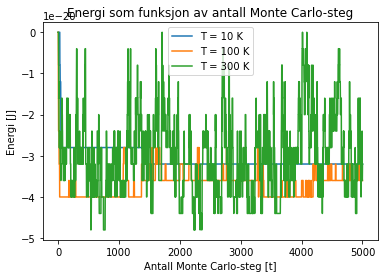

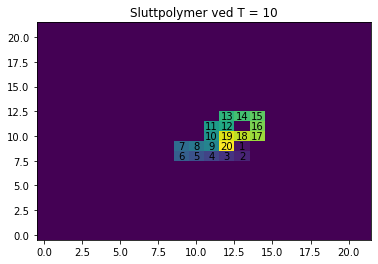

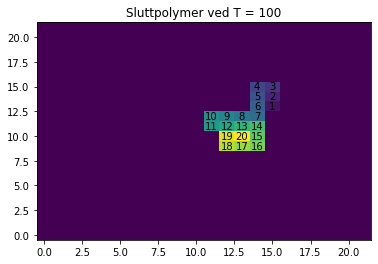

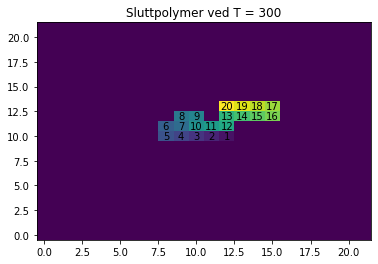

In [101]:
N = 20
polymer_start = makeStraightPolymer(N)
N_s = 5000
vekselvirkning = -4.0 * 10**(-21) #J
T_lav = 10 #K
T_middels = 100 #K
T_hoy = 300 #K
V_matrise = make_V(polymer_start, vekselvirkning)

#Plotte energi energi som funksjon av antall Monte Carlo-steg
plt.xlabel('Antall Monte Carlo-steg [t]')
plt.ylabel('Energi [J]')
plt.title('Energi som funksjon av antall Monte Carlo-steg')

polymer_T_lav, energi_T_lav = metropolisalgoritmen(polymer_start, N_s, V_matrise, T_lav)
polymer_T_middels, energi_T_middels = metropolisalgoritmen(polymer_start, N_s, V_matrise, T_middels)
polymer_T_hoy, energi_T_hoy = metropolisalgoritmen(polymer_start, N_s, V_matrise, T_hoy)
 
t = np.arange(1, len(energi_T_lav)+1, 1)

plt.plot(t, energi_T_lav, label = f'T = {T_lav} K')
plt.plot(t, energi_T_middels, label = f'T = {T_middels} K')
plt.plot(t, energi_T_hoy, label = f'T = {T_hoy} K')

plt.legend()
plt.show()

#Illustrere sluttpolymeren
illustratePolymer(polymer_T_lav, f'Sluttpolymer ved T = {T_lav}')
illustratePolymer(polymer_T_middels, f'Sluttpolymer ved T = {T_middels}')
illustratePolymer(polymer_T_hoy, f'Sluttpolymer ved T = {T_hoy}')

Vi ser at polymeren som folder seg i lavset temperatur, 10 K, synker fort til et energinivå og blir liggende der. For et rett polymer er det . Dette er et lokalt energiminimum, og sannsynligheten for at polymeren skal rotere til et polymer med høyere energi igjen er veldig lav ved lave temperaturer, noe vi kan se fra modellen om .  Vi kan få simuleringer der dette skjer, men polymeren vil da typisk hoppe ned igjen til et lokalt energiminimum direkte etterpå. Dette kan vi se i simuleringen underf temperaturen 100K. Nå er sannsynligheten for flukseringer stor nok til at vi får en del av dem, men den stabiliserer seg gjerne ned igjen til det samme lokalet energiminimumet, eller et du får ved en annen rotasjon. For høye temperarur

Vi kan se at polymeren som har bøyd seg i høy temperatur er mindre viklet sammen siden flere
sannsynligheten for at polymeren roterer selv om energien blir høyere er større enn for
en polymer som roterer i lavere temperatur. Utdyp senere

Som vi nevnte tidligere i trenger ikke alle elementene i V-matrisen som ikke er null å være like, men den må være symetrisk. Vi skal nå se på et tilfelle der vekselvirkningen mellom monomer 2 og 5, og mellom 7 og 10, er dobbelt så stor som mellom de andre monomerene. Vekselvirkningen mellom de resterende beholder vi lik som i forrige oppgave og ser på et polymer med 20 monomerer. Ser på en lav temperatur slik at polymeren skal legge seg i et lokalt energiminimum.

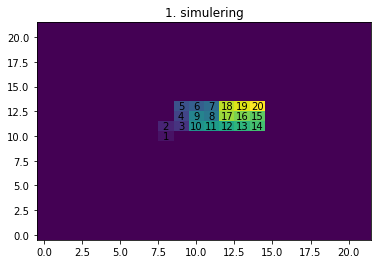

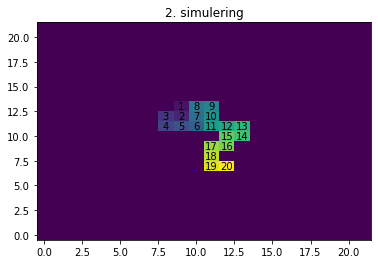

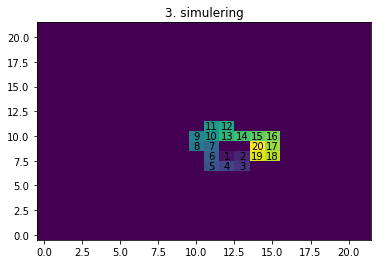

In [102]:
N = 20
T = 300
N_s = 10_000
vekselvirkning = -4.0 * 10**(-21) #J
V_different = make_V(polymer_start, vekselvirkning)

#Endrer noen elementer i V
k = vekselvirkning * 4
V_different[2-1][5-1], V_different[5-1][2-1], V_different[7-1][10-1], V_different[10-1][7-1] = k, k, k, k

#Utfører 3 simuleringer og illustrerer sluttposisjonen
for i in range(3):
    polymer_vElementUnlike = metropolisalgoritmen(makeStraightPolymer(20), N_s, V_different, T)[0]
    illustratePolymer(polymer_vElementUnlike, name = str(i + 1) + '. simulering')

I dette tilfellet vil de lokale energiminimumene med lavest energi vil være de der monomer 2 og 5 ligger ved siden av hverandre og monomer 7 og 10 ligger ved siden av hverandre. I sluttpolymeret i denne simulasjonen, illustrert i figuren over, ser vi at nettopp dette er tilfellet. Dette gir fysisk mening fordi polymeren har har havnet i et lokalt energiminimum den ikke kommer seg ut av ved denne temperaturen.

Ser nå på forventningsverdien til energien som en funksjon temperaturen på intervallet [10, 1000]. 

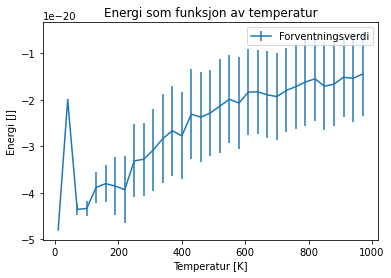

In [103]:
def forventningsVal_E(polymer, N_s, V, T_arr):
    forventningsverdi = np.zeros(len(T_arr))
    standardavvik = np.zeros(len(T_arr))
    
    for i in range(len(T_arr)):
        E_ar = metropolisalgoritmen(polymer, N_s, V, T_arr[i])[1]
        E_ar = E_ar[1000:]
        forventningsverdi[i] = np.average(E_ar)
        standardavvik[i] = np.sqrt(np.average(E_ar**2) - (np.average(E_ar))**2)

    return forventningsverdi, standardavvik

N = 20
N_s = 5000
v_Energy = -4.0 * 10**(-21)

polymer_start = makeStraightPolymer(N)
V = make_V(polymer_start,v_Energy)

T_list = np.arange(10,1000,30)

forventningsverdi, standardavvik = forventningsVal_E(polymer_start, N_s, V, T_list)

#Plotter forventningsverdi for energi som funkjson av temperatur
plt.xlabel('Temperatur [K]')  
plt.ylabel('Energi [J]') 
plt.title('Energi som funksjon av temperatur') 

plt.errorbar(T_list, forventningsverdi, yerr = standardavvik, label = 'Forventningsverdi') 

plt.legend()
plt.show()

Kommentere på knekken. Ser at standardavviket blir større når temperaturen blir større, noe som gir mening fordi
det vil fluksere mer enn et polymer i lav temperatur som kommer til et lokalt energiminimum 
og blir liggende der.

Nå ønkser vi å se nærmere på hva som skjer med polymererne i lavere temperaturer, men ellers med samme forutsetninger som tidligere

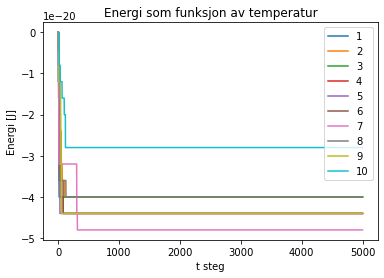

In [104]:
N = 20
N_s = 5000
v_Energy = -4.0 * 10**(-21)
T = 10

polymer_start = makeStraightPolymer(N)
V = make_V(polymer_start,v_Energy)        
t = np.arange(0, N_s + 1, 1)

#Energi, E[t], som funksjon av antall Monte-Carlo-steg ved en fast lav T, N simulasjoner i et plott
plt.xlabel('t steg')  
plt.ylabel('Energi [J]') 
plt.title('Energi som funksjon av temperatur') 
for i in range(10):
    plt.plot(t, metropolisalgoritmen(polymer_start, N_s, V, T)[1], label = str(i+1))
plt.legend()
plt.show()

Spenner ikke ut alt fordi den havner i et lokalt energiminimum, flukturerer ikke ut og dekker hele som for høye temperaturer
Seed (som i frø)? Kan da bedre anslå energien bedre ved et gjennomsnitt. Lokalminimumet kan ligge forskjellig steder på 
forskjellig seeds.
Hvordan og hvorfor kan dette brukes
til ˚a bedre ansl˚a energien til en polymer med lavere temperatur?

2G og H i samme. Forventningsverdi til d som funksjon av T

Execution time of the 1. program is-  105.90598773956299
Execution time of the 2. program is-  106.05759596824646


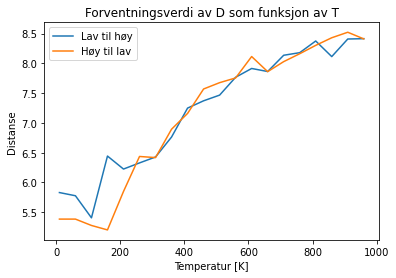

In [105]:
def maxDistance(polymer):
    maxDistance = 1
    for j in range(len(polymer)-1):
        for k in range(j+2, len(polymer)): #Sjekker ikke nabomonomerer siden avstanden uansett er 1
            d = np.linalg.norm(polymer[j] - polymer[k])
            if d > maxDistance:
                maxDistance = d
    return maxDistance
    

def metropolisWithDistance(polymer, N_s, V, T): #bytte N_s med montecarlo steps
    polymer = np.copy(polymer)
    beta = 1/(1.38*10**(-23) * T) #1/(k_b * T), [T] = K
    
    E_array = np.zeros(N_s + 1) #Få riktig indekser
    d_array = np.zeros(N_s + 1)
    E = calculate_energy(polymer, V)
    d_array[0] = maxDistance(polymer)
    i = 0
    while i < N_s:
        koord = polymer[np.random.randint(1, len(polymer)-1)] #Tar ikke med endene
        rot = np.random.randint(0, 2)
        twisted_polymer = rotatePolymer(polymer, koord, rot)
        if polymerIntact(twisted_polymer, N):
            i += 1
            E_new = calculate_energy(twisted_polymer, V)
            if E_new < E:
                polymer = twisted_polymer
                E = E_new

            elif np.random.uniform(0, 1) < math.exp(-beta*(E_new - E)): 
                polymer = twisted_polymer
                E = E_new
            E_array[i] = E
            d_array[i] = maxDistance(polymer)
            
    return polymer, E_array, d_array


def forventningsVal_d(polymer, N_s, V, T_arr):
    forventningsverdi = np.zeros(len(T_arr))
    
    for i in range(len(T_arr)):
        D_ar = metropolisWithDistance(polymer, N_s, V, T_arr[i])[2]
        D_ar = D_ar[1000:]
        forventningsverdi[i] = np.mean(D_ar)

    return forventningsverdi

def forventningsVal_d_reversed(polymer, N_s, V, T_arr):
    forventningsverdi = np.zeros(len(T_arr))
    
    for i in range(len(T_arr)):
        polymer, E_var, D_ar = metropolisWithDistance(polymer, N_s, V, T_arr[i])
        D_ar = D_ar[1000:]
        forventningsverdi[i] = np.average(D_ar)

    return forventningsverdi

N = 20
N_s = 5000
T_list = np.arange(10, 1000, 50)
T_list_reversed = np.flip(T_list)

polymer_start = makeStraightPolymer(N)
vEnergy = np.random.randint(-6, -2) * 10**(-21)
V = make_V(polymer_start, vEnergy)
 
#Forventningsverdi for d, start nederst
start = time.time()

forventningsverdi_d = forventningsVal_d(polymer_start, N_s, V, T_list)

end = time.time()
print("Execution time of the 1. program is- ", end-start)

#Forventningsverdi for d, start øverst
start = time.time()

forventningsverdi_d_reversed = forventningsVal_d_reversed(polymer_start, N_s, V, T_list_reversed)

end = time.time()
print("Execution time of the 2. program is- ", end-start)

#Plotter grafene

plt.xlabel('Temperatur [K]')  
plt.ylabel('Distanse') 
plt.title('Forventningsverdi av D som funksjon av T') 

plt.plot(T_list, forventningsverdi_d, label = 'Lav til høy')
plt.plot(T_list_reversed, forventningsverdi_d_reversed, label = 'Høy til lav')

plt.legend()
plt.show()

Vi ser at forventningsverdien for lengste distanse over polymeren øker med temperaturen. Dette er fordi den vil flukturere mer til posisjoner med høyere energinivåer, som også er mindre sammenkrøllet og lenger distanse. Vi ser den første modellen, hvor vi begynner med et rett polymer fra i lavere temperaturer, gir stor variasjon for lave temeraturer. Dette er fordi vi ikke egentlig vil finne rette polymerer i denne temperaturen, og tilfeldigheter i de første stegene har en relativt stor betydning for nøyaktigheten av forventningsverdien til distansen. I den andre modellen simulerer vi derimot en nedkjøling av et polymer, noe som vil være en mer nøyaktig metode. Vi begynner med et rett polymer under en høy temeratur, noe som kan være fysisk mulig på fluksjoner til høyere energinivåer, og hvert fall mer sannsynlig enn for i den andre modellen der bi 

## Konklusjon

Vi har nå sett på hvordan man kan simulere en polymerfolding i to dimensjoner og hvordan temperaturen i omgivelsene er med på å påvirke energien til polymeren og da også hvordan den blir seende ut. En polymer som formes i høy tempratur roterte vekk fra seg selv og strakk seg ut, mens en polymer i lavere temperatur krøllet seg mer sammen. Vi så også på forskjellen mellom å forme en polymer i økende og avtakende temperatur. Fra resultatene våre i (2g og 2h) så vi at .... 